100%|██████████| 26.4M/26.4M [00:02<00:00, 11.4MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 197kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.71MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 12.9MB/s]


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

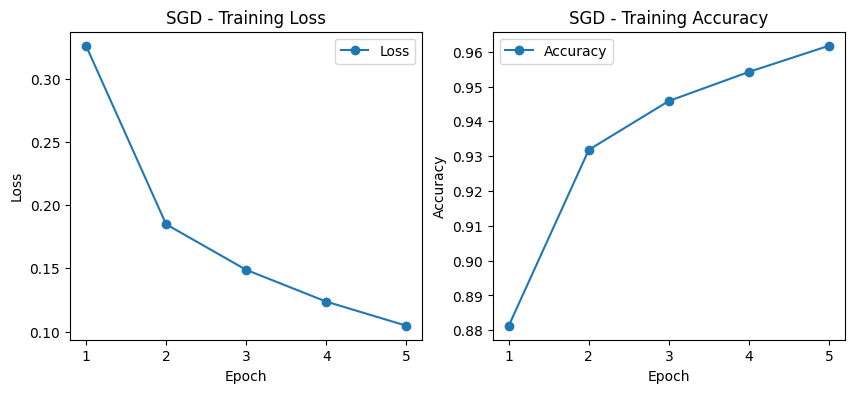

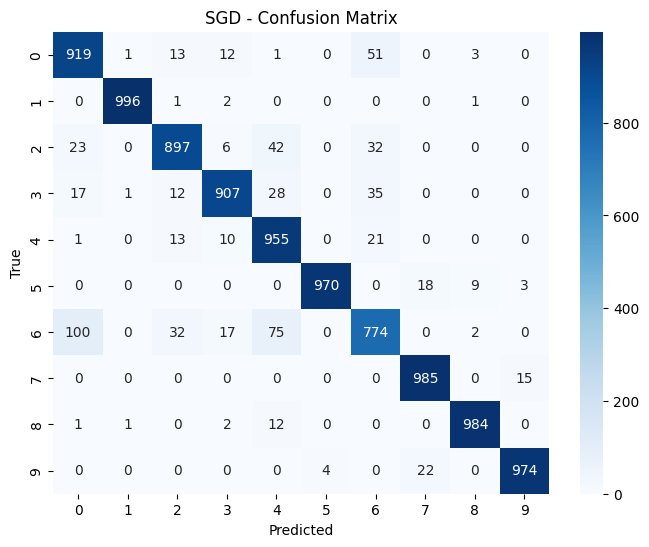

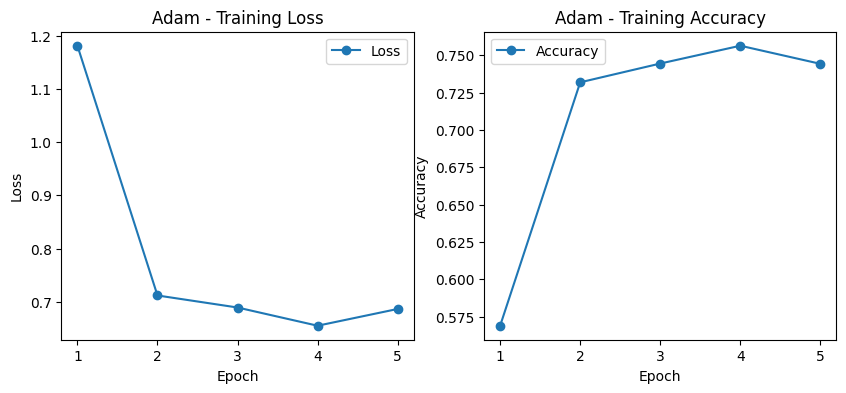

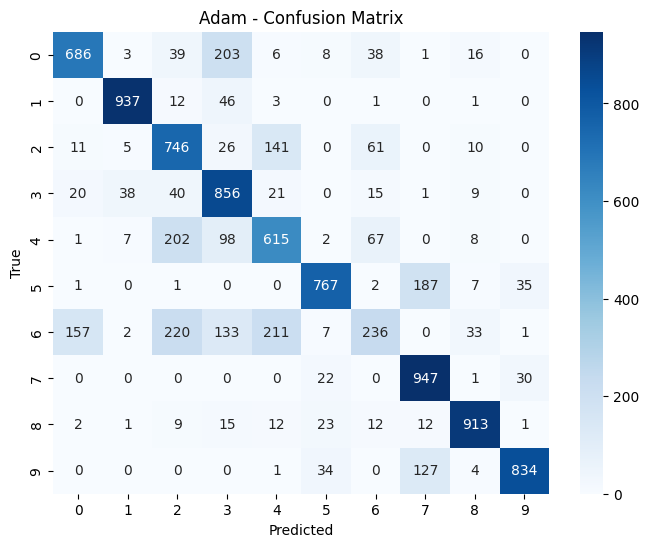

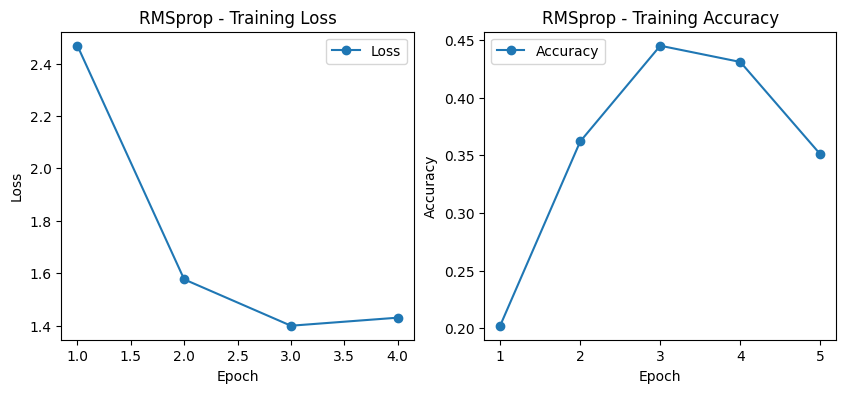

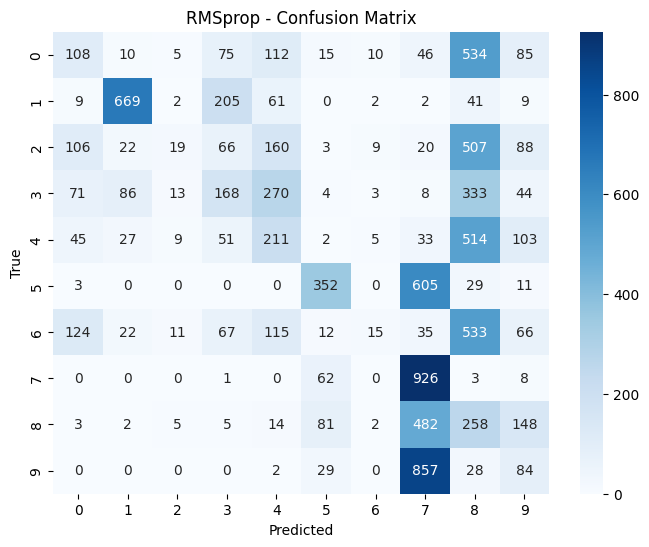

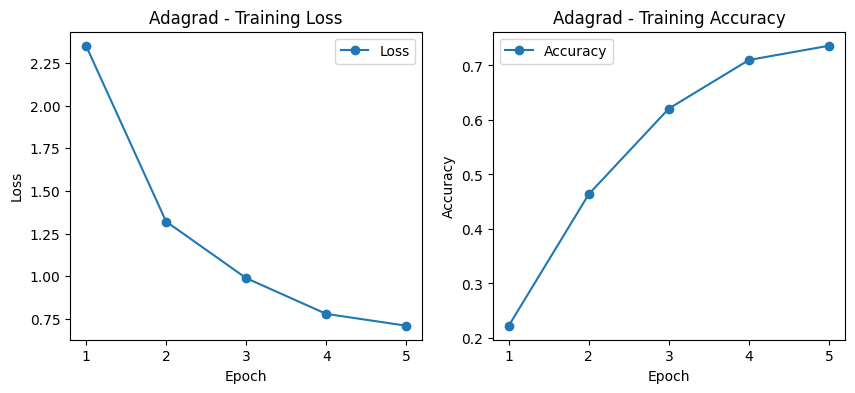

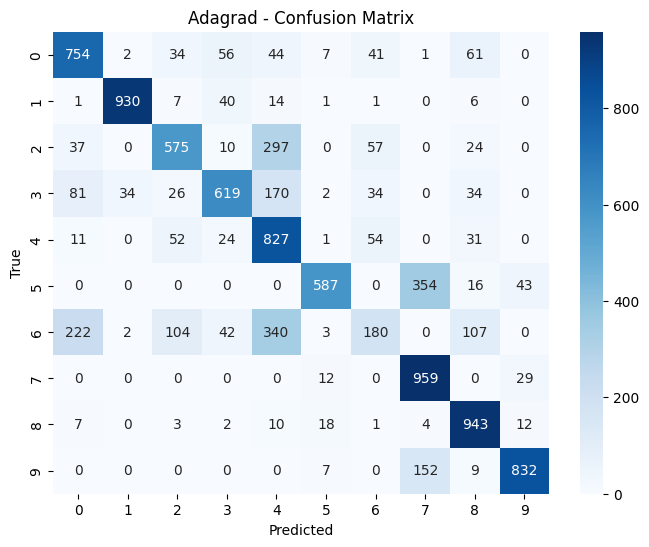

  Optimizer  Test Accuracy  Test Loss  Training Time (s)
0       SGD         0.9361   0.189673        2256.106865
1      Adam         0.7537   0.657010        2282.284696
2   RMSprop         0.2810   1.852803        2112.477354
3   Adagrad         0.7206   0.755255        2204.499946


In [ ]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader
from timm import create_model
import warnings
warnings.filterwarnings("ignore")  # Suppress warnings

# Load FashionMNIST dataset
transform = transforms.Compose([
    transforms.Grayscale(3),  # Convert to 3 channels
    transforms.Resize((224, 224)),  # Adjusted resolution to match model requirements
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset_train = datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)
dataset_test = datasets.FashionMNIST(root="./data", train=False, transform=transform, download=True)

dataloader_train = DataLoader(dataset_train, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
dataloader_test = DataLoader(dataset_test, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

# Define Vision Transformer model
class ViTModel(nn.Module):
    def __init__(self, num_classes=10):
        super(ViTModel, self).__init__()
        self.model = create_model("vit_base_patch16_224", pretrained=True, num_classes=num_classes)

    def forward(self, x):
        return self.model(x)

def train_and_evaluate(optimizer_name):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ViTModel().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = {
        "SGD": optim.SGD(model.parameters(), lr=0.01, momentum=0.9),
        "Adam": optim.Adam(model.parameters(), lr=0.001),
        "RMSprop": optim.RMSprop(model.parameters(), lr=0.001),
        "Adagrad": optim.Adagrad(model.parameters(), lr=0.01)
    }[optimizer_name]

    scaler = torch.cuda.amp.GradScaler()  # Enable mixed precision

    # Training loop
    train_losses, train_acc = [], []
    start_time = time.time()
    for epoch in range(5):
        correct, total, epoch_loss = 0, 0, 0
        model.train()
        for images, labels in dataloader_train:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():  # Enable mixed precision
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            epoch_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        train_losses.append(epoch_loss / len(dataloader_train))
        train_acc.append(correct / total)

    training_time = time.time() - start_time

    # Testing loop
    model.eval()
    correct, total, test_loss = 0, 0, 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in dataloader_test:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    test_accuracy = correct / total
    test_loss /= len(dataloader_test)

    # Plot loss & accuracy
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, 6), train_losses, marker='o', label="Loss")
    plt.title(f"{optimizer_name} - Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, 6), train_acc, marker='o', label="Accuracy")
    plt.title(f"{optimizer_name} - Training Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
    plt.title(f"{optimizer_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return optimizer_name, test_accuracy, test_loss, training_time

# Run for all optimizers
results = []
for opt in ["SGD", "Adam", "RMSprop", "Adagrad"]:
    results.append(train_and_evaluate(opt))

# Print summary table
import pandas as pd
results_df = pd.DataFrame(results, columns=["Optimizer", "Test Accuracy", "Test Loss", "Training Time (s)"])
print(results_df)